In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# Specify the desired input shape for VGG16
input_shape = (224, 224, 3)  # VGG16 requires input shape to be (224, 224, 3)

In [4]:
# Create an ImageDataGenerator with rescaling and resizing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: tf.image.resize(x, (input_shape[0], input_shape[1])),
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50,
    fill_mode='nearest'
)

In [5]:
# Specify the path to your dataset
dataset_path = "C:/Users/user_99/Desktop/data_of_parikar"

In [6]:
# Create data generators for training, validation, and test
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 11441 images belonging to 13 classes.
Found 2851 images belonging to 13 classes.


In [7]:
# Further split the validation_generator into validation and test generators
validation_split = 0.5  # 20% of the original dataset for validation
test_split = 0.5  # 20% of the original dataset for test

num_validation_samples = int(validation_split * validation_generator.samples)
num_test_samples = int(test_split * validation_generator.samples)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important: Set shuffle to False to ensure consistency between validation and test splits
)

test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

# Adjust the number of validation and test steps based on your batch size
num_validation_steps = num_validation_samples // 32
num_test_steps = num_test_samples // 32

Found 2851 images belonging to 13 classes.
Found 2851 images belonging to 13 classes.


In [8]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [9]:
# Freeze the convolutional base, unfreeze the last 3 convolutional layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

In [10]:
# Create a new model with additional dense layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(13, activation='softmax'))

In [11]:
# Compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Train the model using the data generators and save the history
history = model.fit(train_generator, epochs=100, validation_data=validation_generator)

Epoch 1/100
358/358 [==============================] - 233s 629ms/step - loss: 1.1597 - accuracy: 0.6257 - val_loss: 0.8082 - val_accuracy: 0.7464
Epoch 2/100
358/358 [==============================] - 218s 609ms/step - loss: 0.7353 - accuracy: 0.7710 - val_loss: 0.6361 - val_accuracy: 0.7938
Epoch 3/100
358/358 [==============================] - 217s 607ms/step - loss: 0.6090 - accuracy: 0.8089 - val_loss: 0.6512 - val_accuracy: 0.8022
Epoch 4/100
358/358 [==============================] - 217s 607ms/step - loss: 0.5675 - accuracy: 0.8247 - val_loss: 0.5858 - val_accuracy: 0.8309
Epoch 5/100
358/358 [==============================] - 219s 612ms/step - loss: 0.5179 - accuracy: 0.8419 - val_loss: 0.5944 - val_accuracy: 0.8285
Epoch 6/100
358/358 [==============================] - 218s 610ms/step - loss: 0.5074 - accuracy: 0.8466 - val_loss: 0.6238 - val_accuracy: 0.8225
Epoch 7/100
358/358 [==============================] - 219s 611ms/step - loss: 0.4765 - accuracy: 0.8571 - val_loss: 0

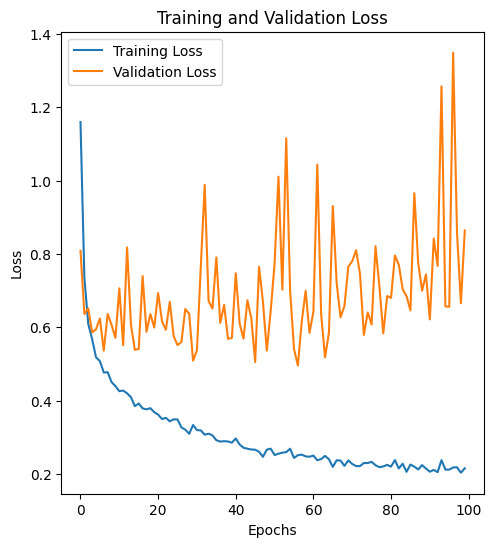

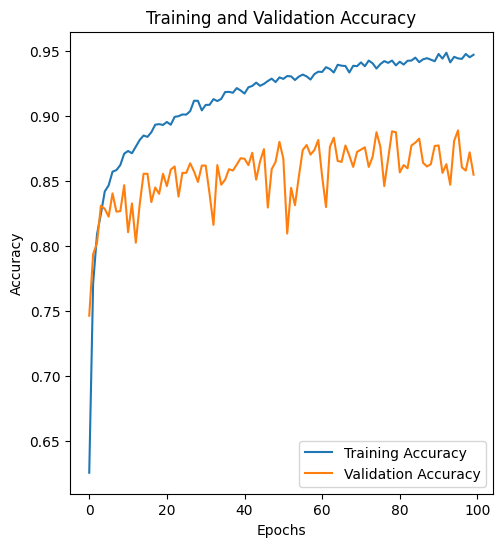

Training and validation loss plot saved at: C:/Users/user_99/Desktop/training_validation_loss_plot.jpg
Training and validation accuracy plot saved at: C:/Users/user_99/Desktop/training_validation_accuracy_plot.jpg


In [13]:
# Save the training and validation loss plots as JPG files
save_dir = "C:/Users/user_99/Desktop/"
save_file_loss = os.path.join(save_dir, "training_validation_loss_plot.jpg")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_file_loss)
plt.show()
plt.close()

# Save the training and validation accuracy plots as JPG files
save_file_accuracy = os.path.join(save_dir, "training_validation_accuracy_plot.jpg")

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(save_file_accuracy)
plt.show()
plt.close()

# Display the saved file paths
print(f"Training and validation loss plot saved at: {save_file_loss}")
print(f"Training and validation accuracy plot saved at: {save_file_accuracy}")

In [14]:
# Evaluate the model on the validation set
validation_results = model.evaluate(validation_generator, steps=num_validation_steps)
print("Validation Loss:", validation_results[0])
print("Validation Accuracy:", validation_results[1])

# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=num_test_steps)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

44/44 [==============================] - 21s 474ms/step - loss: 0.5112 - accuracy: 0.9119
Validation Loss: 0.5111865401268005
Validation Accuracy: 0.9119318127632141
44/44 [==============================] - 21s 473ms/step - loss: 0.5733 - accuracy: 0.9119
Test Loss: 0.5733185410499573
Test Accuracy: 0.9119318127632141


In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


tflite_model_path = "C:/Users/user_99/Desktop/tflite_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user_99\AppData\Local\Temp\tmpwsb7opsv\assets


INFO:tensorflow:Assets written to: C:\Users\user_99\AppData\Local\Temp\tmpwsb7opsv\assets


In [18]:
# Convert the model to TensorFlow Lite with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_path = "C:/Users/user_99/Desktop/tflite_model_vgg16.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user_99\AppData\Local\Temp\tmpsmgdhyj5\assets


INFO:tensorflow:Assets written to: C:\Users\user_99\AppData\Local\Temp\tmpsmgdhyj5\assets
